In [1]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [118]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.inspection import permutation_importance
import tensorflow as tf

# Data input

Import socio-demographic data (codes from Yuchen)

In [3]:
df_sd=pd.read_csv(r"../../02_Data/02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()

df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()
df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()

Calculate case growth rate (codes from Yuchen)

In [4]:
df_case = pd.read_csv(r"../../02_Data/01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)

mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])
    
# The log value
for i in range(len(mData1)-1):
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    pass
del mData1[0]

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:23<00:00, 135.92it/s]


In [5]:
df_case_delta = pd.DataFrame(mData1)
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

In [6]:
df_case_delta.head()

,index,fips,county,state,lat,long,date,cases,state_code,deaths,cases_7,deaths_7,day_index,delta_case
3,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,10.285714,0.0,7,0.102279
4,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,11.000000,0.0,8,0.067139
5,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,11.714286,0.0,9,0.062914
6,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,12.285714,0.0,10,0.047628
7,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,12.571429,0.0,11,0.022990


# Define second wave
Eyeballing approach.
<p> Method 1: look at the trend of the total cases in US.

In [7]:
# calculate new cases 
df_case['new_cases']=df_case['cases'].groupby(df_case['fips']).diff().fillna(0)
df_case['new_cases']=df_case['new_cases'].clip(lower=0)
    ## Calculate 7-day moving average
df_case['cases_7day_ave'] = df_case.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

# calculate total new covid cases in US
us_total=df_case.groupby('date', as_index=False).agg({"cases_7day_ave":"sum"})

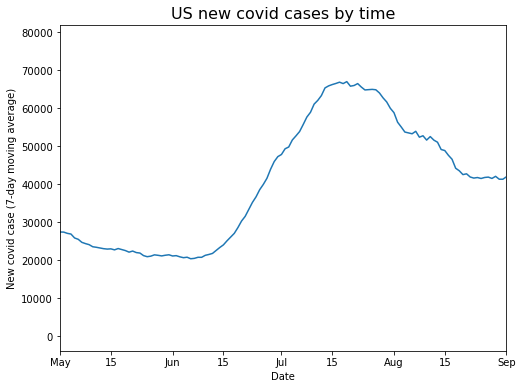

In [8]:
us_total['date']=pd.to_datetime(us_total['date'])

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases_7day_ave",
             data=us_total)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_xlabel('Date')
g.set_ylabel('New covid case (7-day moving average)')
plt.title("US new covid cases by time",fontsize=16)
plt.show()

Method 2: look at the case growth rate.

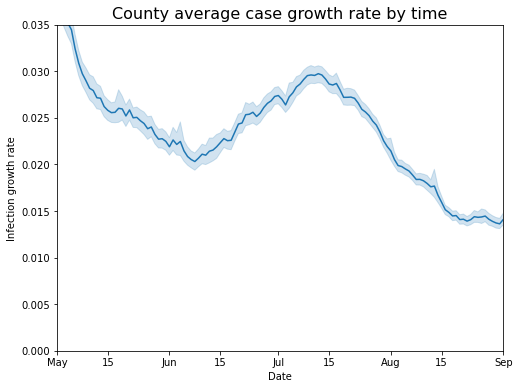

In [9]:
# case growth rate
df_case_delta['date']=pd.to_datetime(df_case_delta['date'])

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="delta_case",
             data=df_case_delta)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_ylim(0,0.035)
g.set_xlabel('Date')
g.set_ylabel('Infection growth rate')
plt.title("County average case growth rate by time",fontsize=16)
plt.show()

Given the trend shown in these two figures, we define the beginning of second wave as June 15, and use the mobility data between May 15 to June 15 to predict the average COVID case growth June 15 - July 15 in each county.

# Prepare predictors

(1) Re-open early: 0-1, if stop stay-at-home order before May 15 defines as 1.
<p> (2) Face mask wearing habit: continuous score. Assign score 1 to 5 for "never" to "always" and calculate the score for each county. 
<p> (3) Socio-demographic characteristics of the county
<p> (4) Mobility by places May 15- Jun 15
<p> (5) Average temperature of May-June.

In [10]:
# reopen time
    ## set Mar 15 as day 0 and get the reopening time for each place
df_policy = pd.read_excel(r"../../02_Data/03_Policy/COVID_StatePolicy_final.xlsx")

df_policy['reopen_early']=[1 if pd.to_datetime(x)<pd.to_datetime('2020-05-15')
                        else 0 for x in df_policy['end_stay_at_home']]

df_policy['reopen_home']=(df_policy['end_stay_at_home'].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
df_policy['reopen_home']=df_policy['reopen_home'].fillna(0)
df_policy['facemask']=(df_policy['facemask'].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
df_policy['facemask']=df_policy['facemask'].fillna(0)

reopen_list=df_policy.columns.values[13:18]
for pol in reopen_list:
    df_policy[pol]=(df_policy[pol].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
    df_policy[pol]=df_policy[pol].fillna(0)
    
df_policy=df_policy.drop(['state_fips','emergency','stay_at_home','gathering','end_stay_at_home',
               'close_school','close_nonessential_business','close_restaurant','close_gym',
               'close_theater','close_bar'],axis=1)
df_policy.head()

,state,state_code,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask,reopen_early,reopen_home
0,Alabama,AL,46.0,57.0,57.0,68.0,57.0,123.0,1,46.0
1,Alaska,AK,40.0,40.0,54.0,54.0,54.0,40.0,1,40.0
2,Arizona,AZ,54.0,57.0,59.0,62.0,62.0,0.0,0,62.0
3,Arkansas,AR,50.0,57.0,50.0,64.0,65.0,127.0,0,0.0
4,California,CA,54.0,64.0,0.0,0.0,0.0,95.0,0,0.0


In [11]:
# facemask
df_facemask = pd.read_csv(r"../../02_Data/07_Facemask/county_facemask.csv",index_col=0)
df_facemask['facemask_score']=1*df_facemask['facemask_never']+2*df_facemask['facemask_rarely']+3*df_facemask['facemask_sometimes']+4*df_facemask['facemask_frequently']+5*df_facemask['facemask_always']
df_facemask=df_facemask.drop(columns='countyfp')
df_facemask.describe()

,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,fips,facemask_score
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,0.079940,0.082919,0.121318,0.207725,0.508094,30383.649268,3.981097
std,0.058538,0.055464,0.058011,0.063571,0.152191,15162.508374,0.413002
min,0.000000,0.000000,0.001000,0.029000,0.115000,1001.000000,2.433000
25%,0.034000,0.040000,0.079000,0.164000,0.393250,18177.500000,3.682000
50%,0.068000,0.073000,0.115000,0.204000,0.497000,29176.000000,3.992000
75%,0.113000,0.115000,0.156000,0.247000,0.613750,45080.500000,4.291750
max,0.432000,0.384000,0.422000,0.549000,0.889000,56045.000000,4.849000


In [12]:
# average case growth Jun 15 to Jul 15
df_case_secondwave=df_case_delta[(df_case_delta['date']>="2020-06-15")&(df_case_delta['date']<="2020-07-15")]
df_casegrowth=df_case_secondwave.groupby('fips', as_index=False).agg({"delta_case":"mean"})
print(df_casegrowth['delta_case'].describe())

# put quartile as predictors
df_casegrowth['quar_case']=pd.qcut(df_casegrowth['delta_case'],2, labels=["low", "high"])
df_casegrowth['high_case']=1*(df_casegrowth['quar_case']=="high")
df_casegrowth=df_casegrowth.drop(columns=['quar_case'],axis=1)
df_casegrowth.head()

count    2762.000000
mean        0.028772
std         0.023138
min         0.000434
25%         0.012683
50%         0.023698
75%         0.038466
max         0.249496
Name: delta_case, dtype: float64


,fips,delta_case,quar_case
0,1001,0.024863,high
1,1003,0.045956,high
2,1005,0.019725,low
3,1007,0.026791,high
4,1009,0.039990,high


In [13]:
# weather
df_weather = pd.read_csv(r"../../02_Data/06_Weather/county_av_tem.csv",index_col=0)
df_weather_sub=df_weather[(df_weather['month']>=5)&(df_weather['month']<=6)]
df_weather_sub=df_weather_sub.groupby('fips', as_index=False).agg({"av_tem":"mean"})
df_weather_sub.head()

,fips,av_tem
0,1001.0,74.050
1,1003.0,74.725
2,1005.0,68.400
3,1007.0,73.050
4,1009.0,69.400


In [14]:
df_weather_sub.head()

,fips,av_tem
0,1001.0,74.050
1,1003.0,74.725
2,1005.0,68.400
3,1007.0,73.050
4,1009.0,69.400


In [15]:
# mobility
df_mob = pd.read_csv("../../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")
df_mob = df_mob.drop(labels='census_fips_code', axis=1)
df_mob['metro_area'].notnull().values.any()
df_mob.describe()

    ## impute missing data. Since workplace mobility is more complete, we will use this column to impute the others. (based on MAR imputation)
missing_list=df_mob.columns.values[7:13]
for col in missing_list:
    ols_imputer_mar=LinearRegression().fit(df_mob.dropna(axis=0,subset=['workplaces_percent_change_from_baseline',col])[['workplaces_percent_change_from_baseline']],
                                       df_mob.dropna(axis=0,subset=['workplaces_percent_change_from_baseline',col])[col])    
    x1hat_impute = pd.Series(ols_imputer_mar.predict(df_mob[['workplaces_percent_change_from_baseline']].dropna()))
    df_mob[col] = df_mob[col].fillna(x1hat_impute)
    
    ## keep county-level data
df_mob_county=df_mob.dropna(axis=0,subset=["sub_region_2"])
df_mob_county=df_mob_county.drop(columns=['country_region_code','country_region','metro_area','iso_3166_2_code'])
df_mob_county=df_mob_county.rename(columns={'sub_region_1':'state','sub_region_2':'county'})
df_mob_county.head()

    ## calculate average mobility May 15 to Jun 14
df_mob_county=df_mob_county[(df_mob_county['date']>="2020-05-15")&(df_mob_county['date']<"2020-06-15")]
df_mob_county=df_mob_county.groupby(['state','county'], as_index=False).agg(["mean"]).reset_index()
df_mob_county.columns = df_mob_county.columns.droplevel(1)

df_mob_county.head()

,state,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,Autauga County,-1.612903,11.354839,38.681145,-9.377769,-23.774194,7.776077
1,Alabama,Baldwin County,7.129032,21.161290,78.677419,7.129032,-20.161290,4.967742
2,Alabama,Barbour County,6.139136,3.579382,41.330788,-4.050949,-17.741935,4.806220
3,Alabama,Bibb County,-8.286333,3.742846,39.531298,-7.668629,-21.838710,6.242938
4,Alabama,Blount County,0.645161,9.486437,38.227730,-10.289311,-24.806452,7.213913


In [74]:
# merge the data
    ## socio-demographic
df_merge=df_sd.copy()
    ## add case growth (Jun 15- Jul 15)
df_merge=df_merge.merge(df_casegrowth, on=['fips'],how='left')
    ## add mobility
df_merge=df_merge.merge(df_mob_county, on=['state','county'],how='left')
    ## add face mask
df_merge=df_merge.merge(df_facemask, on=['fips'],how='left')
    ## add reopen time
df_merge=df_merge.merge(df_policy, on=['state','state_code'],how='left')
df_merge
    ## weather
df_merge=df_merge.merge(df_weather_sub, on=['fips'],how='left')

df_merge.head()

,index,fips,county,state,state_code,median_age_2017,population_2017,female_percentage_2017,lat,long,...,facemask_score,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask,reopen_early,reopen_home,av_tem
0,1,1001,Autauga County,Alabama,AL,37.8,55200,51.315217,32.534923,-86.642730,...,4.003,46.0,57.0,57.0,68.0,57.0,123.0,1.0,46.0,74.050
1,2,1003,Baldwin County,Alabama,AL,42.8,208107,51.376936,30.727479,-87.722564,...,3.967,46.0,57.0,57.0,68.0,57.0,123.0,1.0,46.0,74.725
2,3,1005,Barbour County,Alabama,AL,39.9,25782,46.873788,31.869581,-85.393210,...,3.928,46.0,57.0,57.0,68.0,57.0,123.0,1.0,46.0,68.400
3,4,1007,Bibb County,Alabama,AL,39.9,22527,46.055844,32.998628,-87.126475,...,4.348,46.0,57.0,57.0,68.0,57.0,123.0,1.0,46.0,73.050
4,5,1009,Blount County,Alabama,AL,40.8,57645,50.673953,33.980869,-86.567380,...,3.892,46.0,57.0,57.0,68.0,57.0,123.0,1.0,46.0,69.400


In [75]:
df_merge.columns.values

array(['index', 'fips', 'county', 'state', 'state_code',
       'median_age_2017', 'population_2017', 'female_percentage_2017',
       'lat', 'long', 'Race_Hispanic', 'Race_White', 'Race_Black',
       'Race_Native', 'Race_Asian', 'Race_Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr',
       'Poverty', 'ChildPoverty', 'WorkType_Professional',
       'WorkType_Service', 'WorkType_Office', 'WorkType_Construction',
       'WorkType_Production', 'Transp_Drive', 'Transp_Carpool',
       'Transp_Transit', 'Transp_Walk', 'Transp_OtherTransp',
       'Transp_WorkAtHome', 'MeanCommute', 'Employed', 'Work_PrivateWork',
       'Work_PublicWork', 'Work_SelfEmployed', 'Work_FamilyWork',
       'Work_Unemployment', 'crime_rate_per_100000', 'IDNO',
       'Crime_CPOPARST', 'Crime_CPOPCRIM', 'Crime_AG_ARRST',
       'Crime_AG_OFF', 'Crime_COVIND', 'Crime_MODINDX', 'Crime_MURDER',
       'Crime_RAPE', 'Crime_ROBBERY', 'Crime_AGASSLT', 'Crime_BURGLRY',
     

# Prediction

We will predict the average case growth rate at the beginning of the second wave in US (Jun 15- July 15) using the county socio-demographics, county political ideology, county reopening time by places, county mobility by places in the previous month, county weather condition, and county facemask wearing rate. Instead of using continuous growth rate, our response variable is the below/ above median of growth rate. Thus we will classify counties into two classes. 

This section will proceed in four steps: 
<br> (1) Overfitting multinomial logistic regression model;
<br> (2) Lasso penalized multinomial logistic regression model;
<br> (3) Random Forest classification model; 
<br> (4) ANN classification model. 

In [76]:
df_complete=df_merge.drop([ 'state_code','lat', 'long','IDNO','Income', 'IncomeErr', 'av_tem','reopen_early'],axis=1).dropna()
print(df_complete.shape,df_merge.shape)

(2531, 74) (3220, 82)


In [77]:
# split train-test data
df_train, df_test, = train_test_split(
    df_complete, test_size=0.2,  random_state = 121, shuffle=True
)
print(df_train.shape, df_test.shape)

(2024, 74) (507, 74)


In [79]:
X_train=df_train.drop(['fips', 'county', 'state', 'democrat','delta_case', 'high_case',
                      'facemask_score'],axis=1)
X_test=df_test.drop(['fips', 'county', 'state', 'democrat','delta_case', 'high_case',
                      'facemask_score'],axis=1)

y_train=df_train['high_case']
y_test=df_test['high_case']

In [80]:
scaler = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Logistic regression
(1) Simple logistic regression; (2) Lasso regularized; (3) PCA.

In [81]:
import warnings
warnings.simplefilter("ignore")

In [82]:
logit_basic=LogisticRegression(penalty="none", solver='lbfgs', max_iter = 5000)
logit_basic.fit(X_train,y_train)

logit_basic_train_accuracy = logit_basic.score(X_train_std,y_train)
logit_basic_test_accuracy = logit_basic.score(X_test_std,y_test)

print("The training and testing classification accuracies are:",logit_basic_train_accuracy.round(4),logit_basic_test_accuracy.round(4))

The training and testing classification accuracies are: 0.6502 0.6529


LASSO

In [83]:
import timeit

Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 3
penalty = 'l1'
solver = 'liblinear'

t1 = timeit.default_timer()

lasso_regr = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver=solver,max_iter = 5000
).fit(X_train_std, y_train)

# accuracy
train_score_lasso = lasso_regr.score(X_train_std, y_train)
test_score_lasso = lasso_regr.score(X_test_std, y_test)

train_time = timeit.default_timer() - t1

print(f'The training and testing classification accuracies are: {train_score_lasso: .4f} and {test_score_lasso: .4f}')
print(f'Best regularization parameter {lasso_regr.C_[0]: .4f}')
print(f'Model training time {train_time: .4f}')

The training and testing classification accuracies are:  0.7045 and  0.6805
Best regularization parameter  0.1000
Model training time  31.2697


In [85]:
print(str(np.sum(lasso_regr.coef_==0)) + ' predictors are considered unimportant')
print(f'{np.sum(lasso_regr.coef_!=0)} predictors are considered important in the regularized model')

26 predictors are considered unimportant
41 predictors are considered important in the regularized model


In [90]:
df_lasso_coef=pd.DataFrame({'var': list(X_train.columns.values), 'lasso_coef': list(lasso_regr.coef_[0])}, columns=['var', 'lasso_coef'])
df_lasso_coef['coef_abs']=df_lasso_coef['lasso_coef'].abs()
df_lasso_coef=df_lasso_coef.sort_values(by='coef_abs', ascending=False)
df_lasso_coef[['var','lasso_coef']].head(10)

,var,lasso_coef
48,demo_vote_share,-0.399421
4,Race_Hispanic,0.364402
60,reopen_business,-0.288933
51,parks_percent_change_from_baseline,-0.283682
54,residential_percent_change_from_baseline,-0.275268
19,WorkType_Production,-0.271562
42,Crime_ROBBERY,-0.265206
44,Crime_BURGLRY,0.259547
63,reopen_theater,-0.188151
32,Work_Unemployment,0.180765


Three insights from the results:
<br> (1) Political ideology is the largest predictor for second wave case growth, with the higher share of voters for democrats the lower probability to have high case growth;
<br> (2) Late reopen of business and theater decrease the chances of a county to have high case growth in the second wave;
<br> (3) Mobility is another important factor, with higher mobility at parks and residential places correlated with lower case growth.

PCA

Since there are still many variables considered as important, we can try using PCA to further reduce the dimensions.

Top 2 PCA variance explained:  0.344
number of components that explain at least 90% of the variance= 29


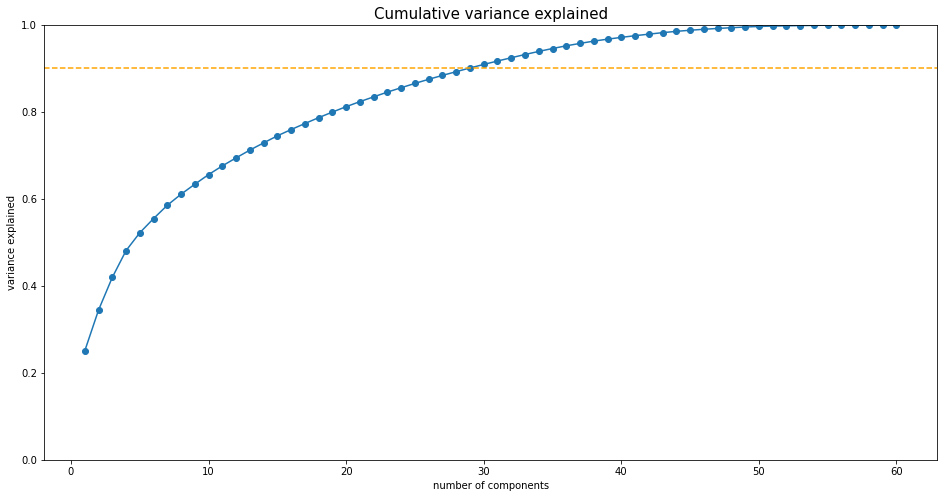

In [91]:
pca = PCA().fit(X_train_std)
pca_xtrain = pca.transform(X_train_std)
pca_xtest = pca.transform(X_test_std)

print( f'Top 2 PCA variance explained: {np.sum(pca.explained_variance_ratio_[0:2]): .3f}')

var_explained = []
total_comp = 60
pca = PCA(n_components = total_comp).fit(X_train_std)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.90, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<0.90)[0])+1)

In [92]:
component=29
pca = PCA(n_components = component).fit(X_train_std)  
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
    
logreg_pca = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logreg_pca.fit(X_train_pca, y_train)

y_train_pred_logreg_pca = logreg_pca.predict(X_train_pca)
y_test_pred_logreg_pca = logreg_pca.predict(X_test_pca)
train_score = accuracy_score(y_train, y_train_pred_logreg_pca)
test_score = accuracy_score(y_test, y_test_pred_logreg_pca)

print(f'The training and testing classification accuracies are: {train_score: .4f} and {test_score: .4f}')

The training and testing classification accuracies are:  0.6937 and  0.6824


### Decision Tree
(1) Simple decision tree;
(2) Random Forest;
(3) Boosting

Simple decision tree

In [95]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    cv_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # Perform 5-fold cross validation and store results
        train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
    # end of your code here
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train_std, y_train, depths)

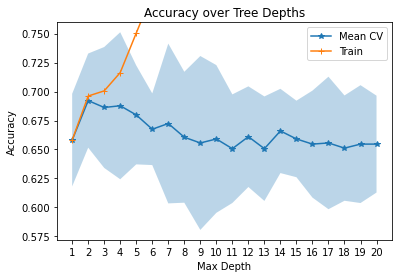

In [96]:
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Accuracy over Tree Depths")
plt.xticks(depths);

In [97]:
best_cv_depth = 2
# once depth is chosen (i.e. hyper-parameters are found), we re-fit the model with all train data (including validation data)
fitted_tree = DecisionTreeClassifier(max_depth=best_cv_depth).fit(X_train_std, y_train)
best_cv_tree_train_score = fitted_tree.score(X_train_std, y_train)
best_cv_tree_test_score = fitted_tree.score(X_test_std, y_test)
print(f"The tree of depth {best_cv_depth} achieved an accuracy of {best_cv_tree_test_score:.3f} on the test set.")

Accuracy: mean=0.692, +/- 2 stdev: [0.652 -- 0.733]
The tree of depth 2 achieved an accuracy of 0.657 on the test set.


Random Forests

In [99]:
tree_depth=10
n_trees = 55 

fitted_rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train_std,y_train)
random_forest_train_score = fitted_rf.score(X_train_std, y_train)
random_forest_test_score = fitted_rf.score(X_test_std, y_test)
print(f"The random forest scored {random_forest_train_score:.3f} on the train set.")
print(f"The random forest scored {random_forest_test_score:.3f} on the test set.")

The random forest scored 0.967 on the train set.
The random forest scored 0.710 on the test set.


In [102]:
top_predictors_rf = [X_train.columns[model.tree_.feature[0]]  for  model in fitted_rf.estimators_ ]
top_predictors_rf_df = pd.DataFrame(pd.Series(top_predictors_rf).value_counts(), columns=['Count'])
display(top_predictors_rf_df)


,Count
reopen_restaurant,8
reopen_bar,7
reopen_gym,6
reopen_theater,6
reopen_business,5
demo_vote_share,3
reopen_home,3
Work_PrivateWork,3
Poverty,3
workplaces_percent_change_from_baseline,2


Boosting

In [116]:
# ! pip install xgboost

In [105]:
dtrain = xgb.DMatrix(X_train_std, label=y_train)
dtest = xgb.DMatrix(X_test_std, label=y_test)

In [114]:
# Parameters
param = {
    'max_depth': 12,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)*100
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)*100


print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[19:29:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.07411
Will train until train-merror hasn't improved in 20 rounds.
[20]	train-merror:0.00000
Stopping. Best iteration:
[7]	train-merror:0.00000

XGBoost:	Accuracy, Training Set 	: 100.00%
XGBoost:	Accuracy, Testing Set 	: 71.60%


### Artificial Neural Networks

In [151]:
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(15, activation='sigmoid',
                       input_shape=(X_train_std.shape[1],),name='hidden-1'))
NN_model.add(tf.keras.layers.Dense(15, activation='sigmoid',name='hidden-2'))

NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid',name='output'))
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden-1 (Dense)             (None, 15)                1020      
_________________________________________________________________
hidden-2 (Dense)             (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
_________________________________________________________________


In [152]:
optimizer=tf.keras.optimizers.Adam(0.001)
NN_model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)
NN_model_history=NN_model.fit(X_train_std,y_train,epochs=50,verbose=0,validation_split=0.2)

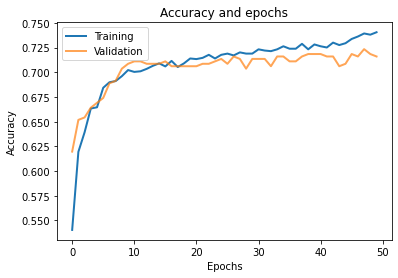

In [153]:
plt.plot(NN_model_history.history['accuracy'],linewidth=2, label = 'Training')
plt.plot(NN_model_history.history['val_accuracy'],linewidth=2, label = 'Validation', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and epochs')
plt.legend()
plt.show()

In [154]:
NN_train_acc=NN_model.evaluate(X_train_std, y_train,verbose=0)[1]
NN_test_acc = NN_model.evaluate(X_test_std, y_test,verbose=0)[1]

print("The training and testing accuracies are", round(NN_train_acc,4), "and", round(NN_test_acc,4))

The training and testing accuracies are 0.7352 and 0.714


Now we try to understand the implications of the results through proxying a logistic regression.

In [161]:
y_predict_train=NN_model.predict_classes(X_train_std).reshape(-1,)
y_predict_test=NN_model.predict_classes(X_test_std).reshape(-1,)

C=0.01
penalty='l2'
solver = 'lbfgs'

logreg=LogisticRegression(C=C,penalty=penalty,solver=solver).fit(X_train_std, y_predict_train)
logreg_train_acc = logreg.score(X_train_std, y_train)
logreg_test_acc = logreg.score(X_test_std, y_test)

print("The training and testing set accuracy are ",round(logreg_train_acc,4),"and ",round(logreg_test_acc,4))

The training and testing set accuracy are  0.708 and  0.7002


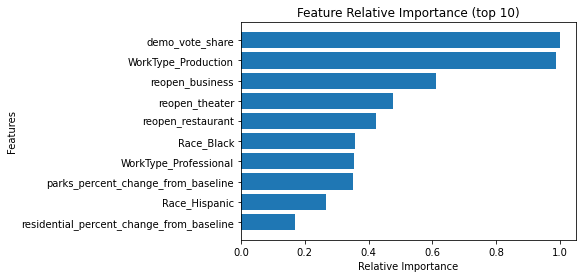

In [163]:
perm_result = permutation_importance(logreg, X_train_std, y_predict_train, n_jobs=-1)
features=X_train.columns.values
top_10=perm_result.importances_mean.argsort()[-10:]
top10_feature= features[top_10]
top10_rel_score=perm_result.importances_mean[top_10]/perm_result.importances_mean.max()

plt.barh(top10_feature, top10_rel_score)
plt.ylabel('Features')
plt.xlabel('Relative Importance')
plt.title('Feature Relative Importance (top 10)')
plt.show()

Again, we see political ideology and reopening of business, restuarant and theater ahead of the list in predicting the second wave, folloed by race and mobility at parks and home.